In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from pymongo import MongoClient

from src.config_tickets import ticket_lst
from src.scraping import WebScraping
from src.settings import HOST
from src.query_data import QueryData

In [3]:
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [4]:
def connect_2_dbServer():
    mongoClient = MongoClient(HOST)
    return mongoClient

In [5]:
client = connect_2_dbServer()
query = QueryData(client)

In [6]:
df_ticket = query.get_list_ticket()
print(df_ticket)

     ticket                            name
0     VNI30                           VN 30
755   HNX30                          HNX 30
1067    ACB            Asia Commercial Bank
1823    VCS     Advanced Compound Stone JSC
2579    BVS      Baoviet Securities Company
3331    BCC                  Bim Son Cement
4086    NDN                  DANANG HOUSING
4842    VTV  Materials Transport Cement JSC
5463    PGS   Petrovietnam Southern Gas JSC


In [7]:
start = datetime(2010,1,1)
end = datetime(2019,1,1)
lst_ticket = list(df_ticket['name'][2:5])

df = query.get_historical_data(lst_ticket, start=start)
closed_price = pd.DataFrame()
for ticket in lst_ticket:
    closed_price[ticket] = df[df.name == ticket]['close']
closed_price.tail()

,Asia Commercial Bank,Advanced Compound Stone JSC,Baoviet Securities Company
date,,,
2016-05-10,12864.00000,26073.00000,12768.00000
2016-05-09,12936.00000,26450.00000,12864.00000
2016-05-06,12792.00000,26775.00000,12864.00000
2016-05-05,12792.00000,27202.00000,12960.00000
2016-05-04,12864.00000,27076.00000,13056.00000


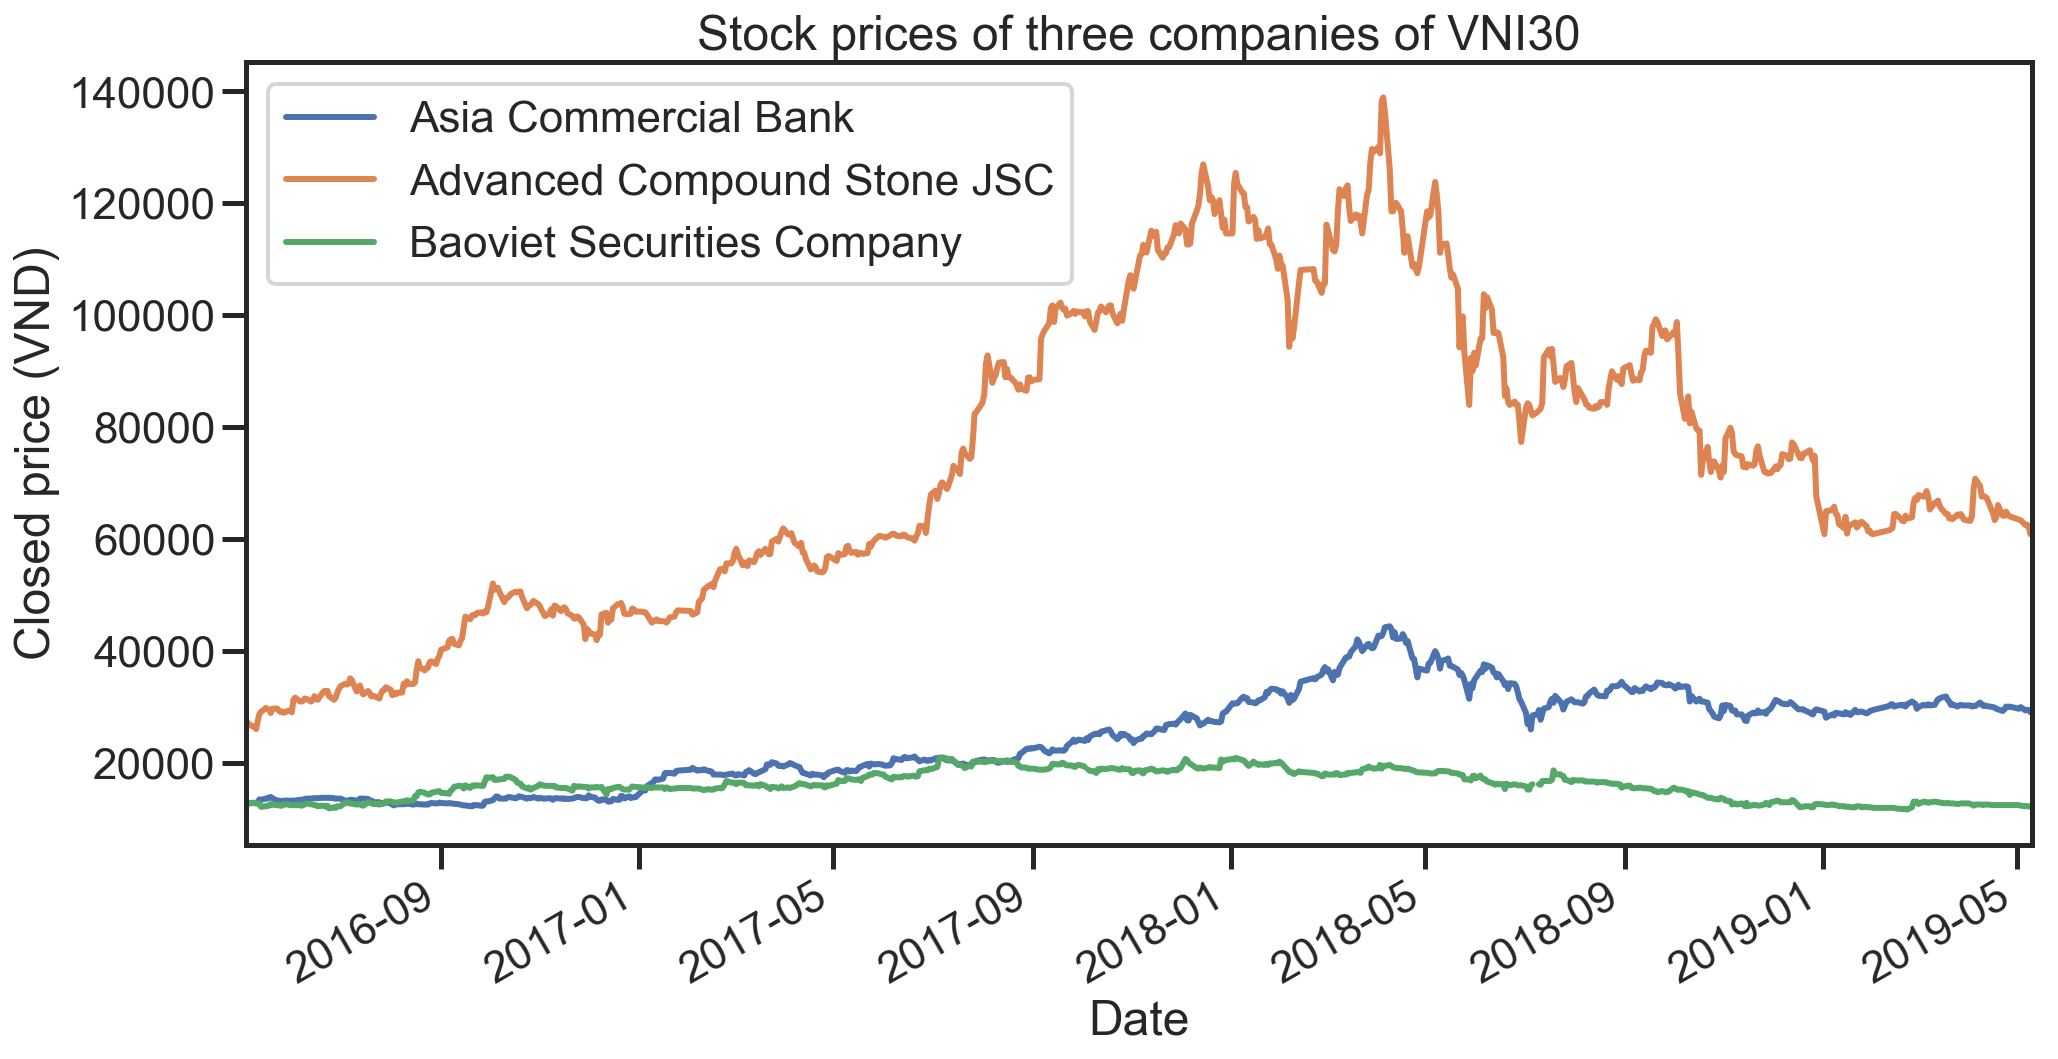

In [8]:
closed_price.plot(figsize=(16,8))
plt.ylabel('Closed price (VND)')
plt.xlabel('Date')
plt.title('Stock prices of three companies of VNI30')
plt.show()

## Plot ACF and PACF

In [9]:
from statsmodels.tsa.stattools import pacf, acf

def calculate_acf(time_series, lag=20, alpha=0.05):
    x = time_series.values
    acf_value, confint = acf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - acf_value
    confint_upper = confint[:, 1] - acf_value
    return acf_value, confint_upper, confint_lower


def calculate_pacf(time_series, lag=20, alpha=0.05):
    x = time_series.values
    pacf_value, confint = pacf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - pacf_value
    confint_upper = confint[:, 1] - pacf_value
    return pacf_value, confint_upper, confint_lower

In [10]:
acf_value, confint_upper, confint_lower = calculate_acf(closed_price['Asia Commercial Bank'])

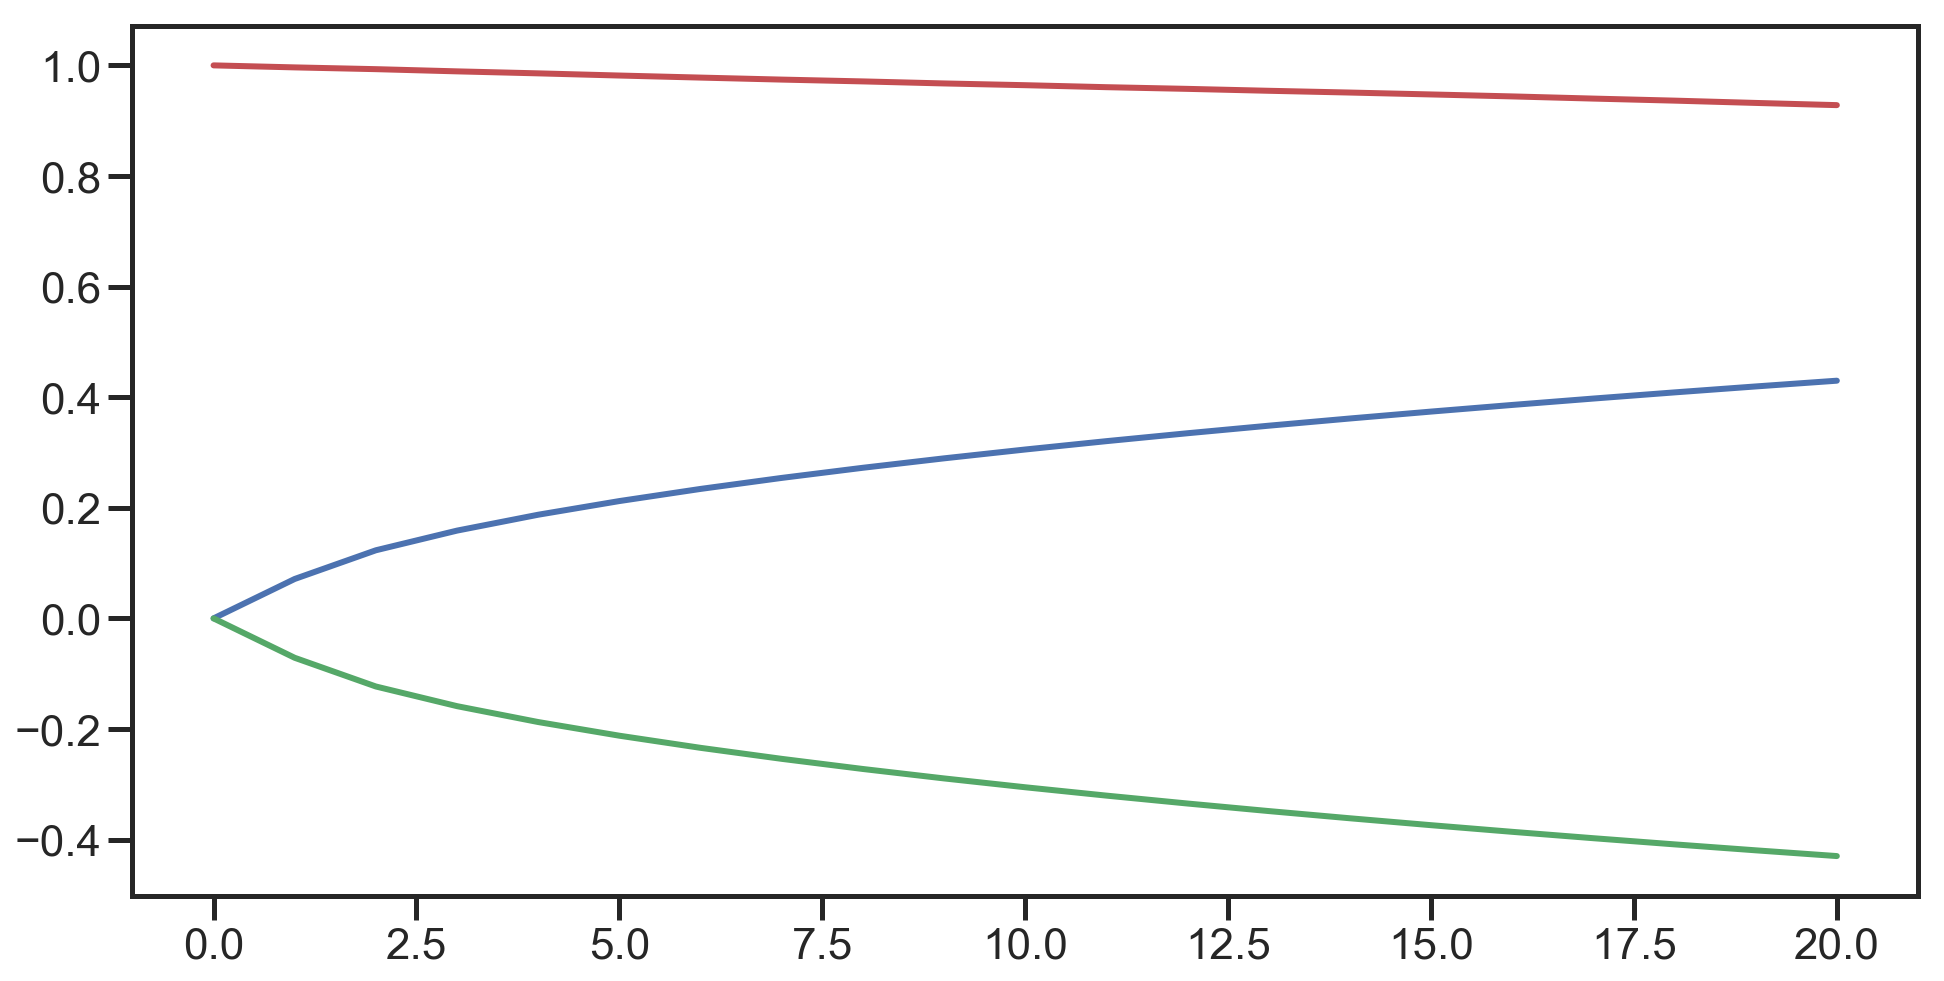

In [11]:
plt.figure(figsize=(16,8))
plt.plot(acf_value, color='r')
plt.plot(confint_upper, color='b')
plt.plot(confint_lower, color='g')
plt.show()

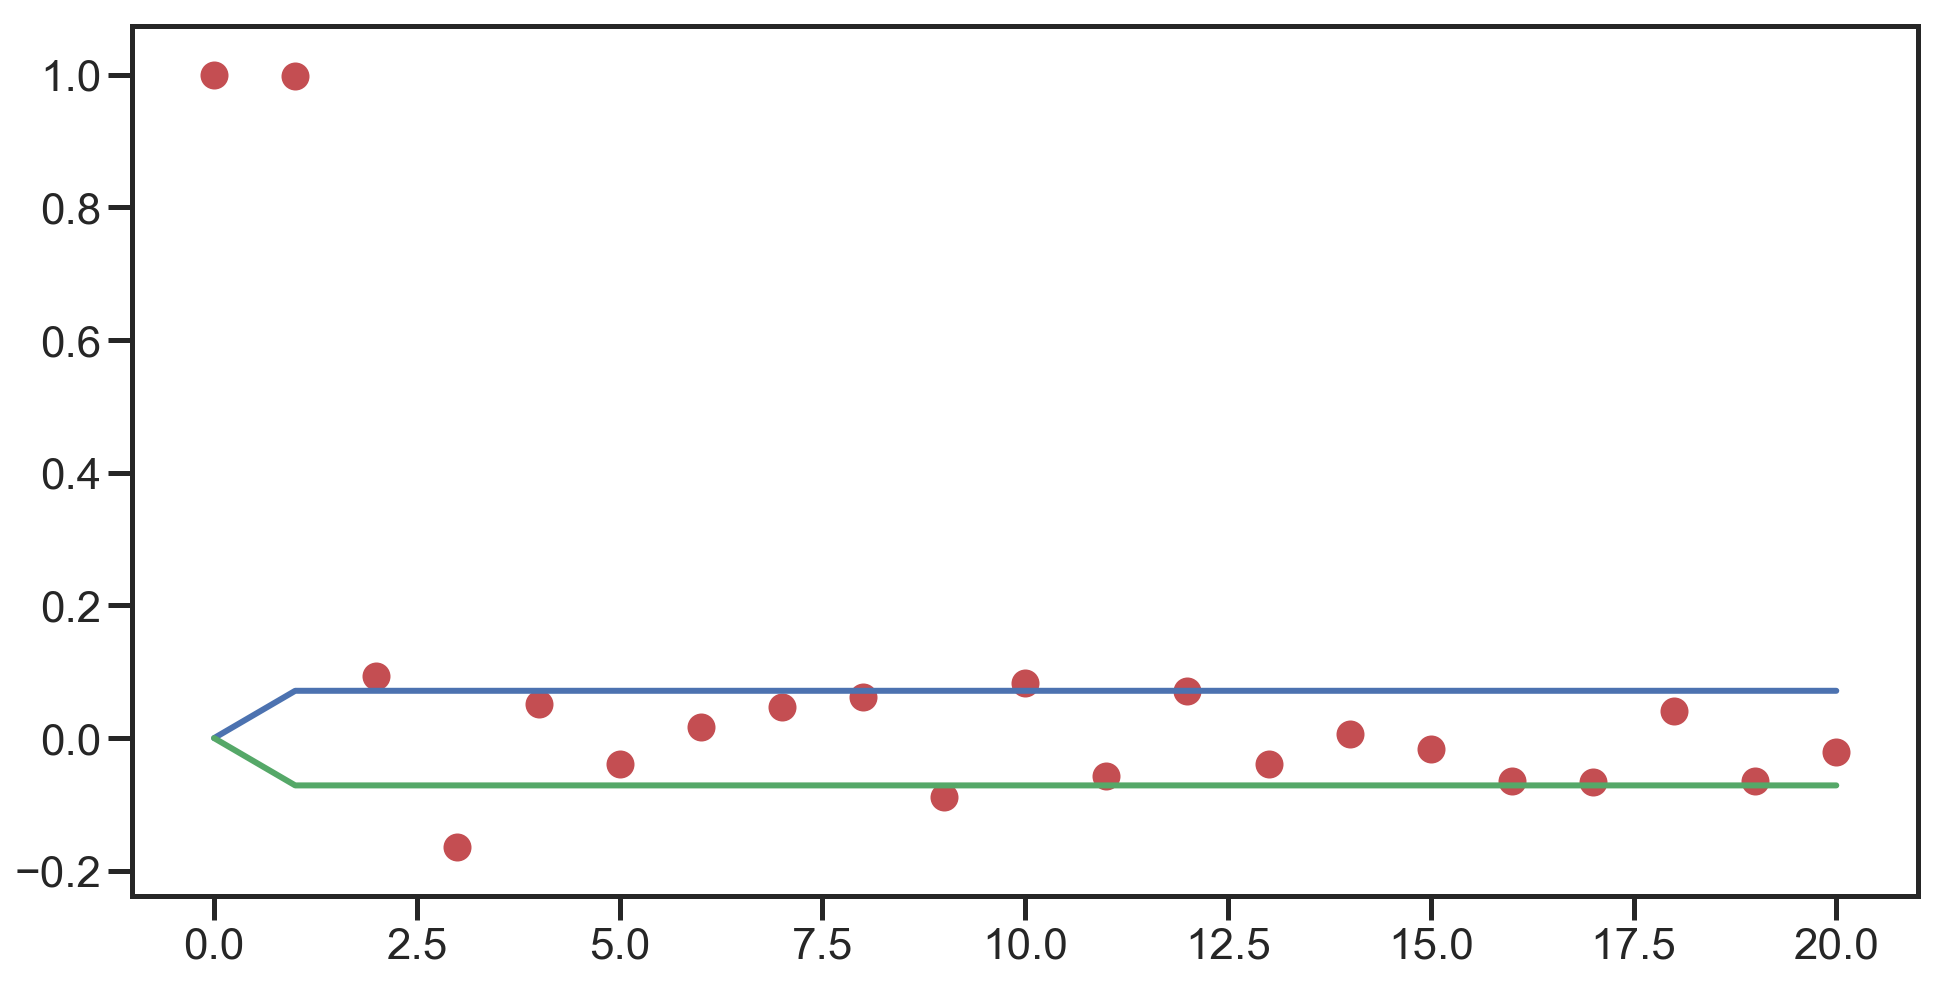

In [12]:
pacf_value, confint_upper, confint_lower = calculate_pacf(closed_price['Asia Commercial Bank'])

plt.figure(figsize=(16,8))
plt.scatter(range(0,21), pacf_value, color='r')
plt.plot(confint_upper, color='b')
plt.plot(confint_lower, color='g')
plt.show()